In [4]:
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from util import prepare_df

In [5]:
df = prepare_df(xp_identifier="oracles")
df.head()

CSV files used by the notebook: 
- header: 20240225_220544_oracles_header.csv
- explo: 20240225_220544_oracles_explo.csv
The total time taken by the simulations is 686.09 min, i.e 11.43 hours.
For scheduler: EDF-VD, 1245 tasks are schedulable and 855 tasks are not schedulable.


,tid,search_type,scheduler,safe,unsafe,schedulable,depth,n_visited,duration,duration_s,ts_id,U,Uv,nbt,EDFVD_test,n_task,Number of tasks,Schedulable,oracle
0,0,ACBFS,EDF-VD,NaN,NaN,True,11,2896,24517064,0.024517,0.0,0.8,0.800992,5.0,0.0,5.0,5.0,True,none
1,0,ACBFS,EDF-VD,all_idle_hi,NaN,True,11,2890,24258914,0.024259,0.0,0.8,0.800992,5.0,0.0,5.0,5.0,True,all_idle_hi
2,0,ACBFS,EDF-VD,edf_carryoverjobs,NaN,True,11,2891,24248494,0.024248,0.0,0.8,0.800992,5.0,0.0,5.0,5.0,True,edf_carryoverjobs
3,0,ACBFS,EDF-VD,NaN,interference,True,11,2896,25582665,0.025583,0.0,0.8,0.800992,5.0,0.0,5.0,5.0,True,interference
4,0,ACBFS,EDF-VD,NaN,hi_interference,True,11,2896,24810790,0.024811,0.0,0.8,0.800992,5.0,0.0,5.0,5.0,True,hi_interference


In [6]:
df["tid"].unique().shape

(2100,)

In [7]:
df["tid"].unique().shape

In [ ]:
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
task_palette = sns.color_palette("deep", int(df["n_task"].unique().shape[0]))
sns.set_theme(style="whitegrid", palette="deep", rc={"figure.figsize": (11.7, 8.27)})

In [8]:
df_root = df[["tid", "n_task", "schedulable", "Number of tasks", "Schedulable"]]
df_root = df_root.set_index("tid")

In [9]:
df_ss = df.pivot(index="tid", columns="oracle", values=["duration_s", "n_visited"])
df_ss.columns = list(map(lambda x: "_".join(x), df_ss.columns))
df_ss = df_root.join(df_ss)

In [10]:
oracle_sort_list = (
    df.groupby("oracle")["n_visited"].median().sort_values().index.to_list()[::-1]
)

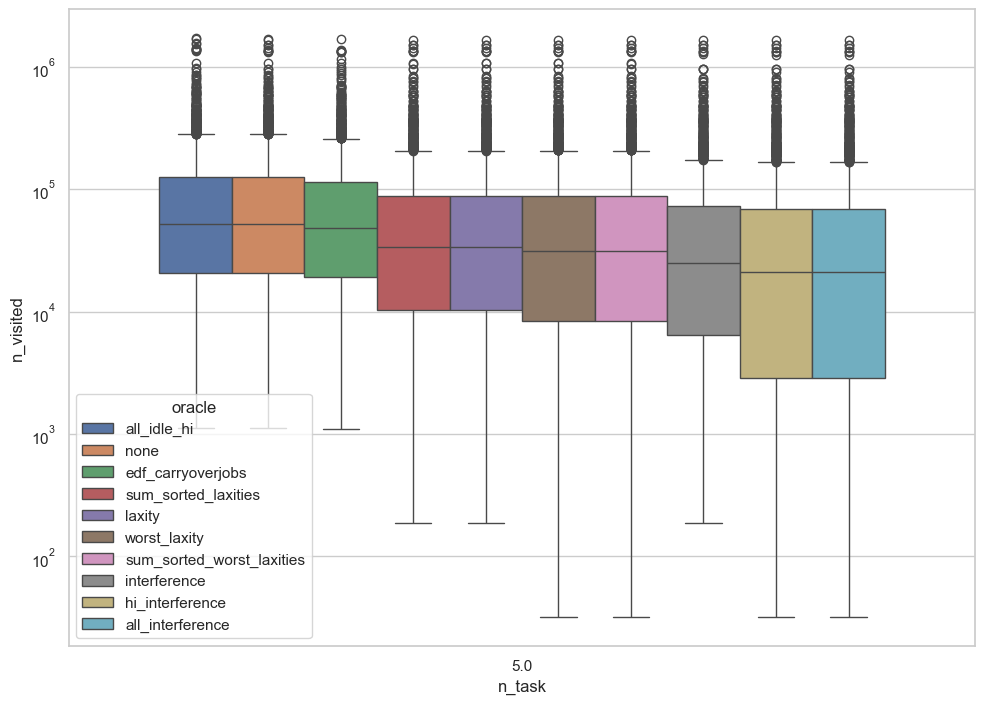

In [11]:
g = sns.boxplot(
    data=df,
    y="n_visited",
    x="n_task",
    hue="oracle",
    hue_order=df.groupby("oracle")["n_visited"]
    .median()
    .sort_values()
    .index.to_list()[::-1],
)
g.set_yscale("log")
plt.show()

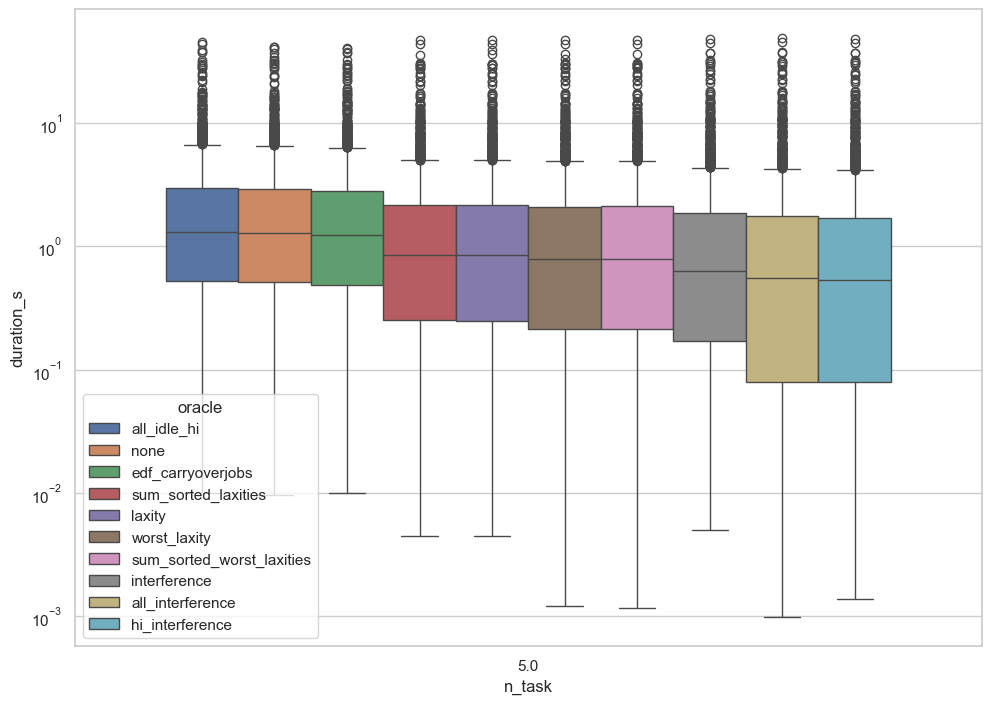

In [12]:
g = sns.boxplot(
    data=df,
    y="duration_s",
    x="n_task",
    hue="oracle",
    hue_order=df.groupby("oracle")["duration_s"]
    .median()
    .sort_values()
    .index.to_list()[::-1],
)
g.set_yscale("log")
plt.show()

In [13]:
df_comp = df.loc[df["oracle"] != "none"].merge(
    df.loc[df["oracle"] == "none", ["tid", "duration_s", "n_visited"]],
    on="tid",
    suffixes=("", "_none"),
)
df_comp["n_visited_ratio"] = df_comp["n_visited"] / df_comp["n_visited_none"]
df_comp["duration_s_ratio"] = df_comp["duration_s"] / df_comp["duration_s_none"]
df_comp["n_visited_change"] = df_comp["n_visited_ratio"] - 1
df_comp["duration_s_change"] = df_comp["duration_s_ratio"] - 1

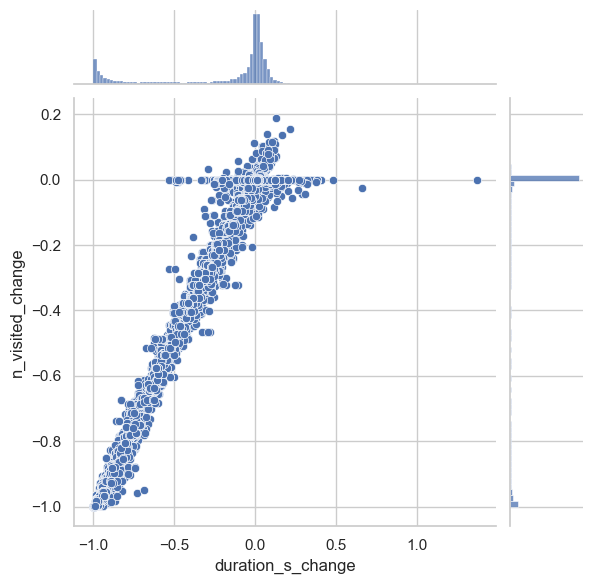

In [14]:
# s = df_comp["oracle"] == "edf_carryoverjobs"

# f = sns.jointplot(data=df_comp.loc[s], x="duration_s", y="duration_s_change", hue="schedulable")
f = sns.jointplot(data=df_comp, x="duration_s_change", y="n_visited_change")
# f.set_yscale("log")

In [33]:
df_comp_melt = df_comp.melt(
    id_vars=["tid", "oracle", "schedulable"],
    value_vars=["n_visited_change", "duration_s_change"],
)


df_comp_melt = df_comp_melt.rename(
    columns={
        "variable": "Dimension",
        "value": "Relative change",
        "schedulable": "Schedulable",
        "oracle": "Oracle",
    }
)

df_comp_melt["Relative change"] = df_comp_melt["Relative change"] * 100

metric_map = {
    "duration_s_change": "Execution time",
    "n_visited_change": "Number of visited states before halt",
}

df_comp_melt["Dimension"] = df_comp_melt["Dimension"].map(lambda x: metric_map[x])

oracle_map = {
    "all_idle_hi": "HI idle point",
    "all_interference": "All interference",
    "interference": "dbf",
    "none": "None",
    "laxity": "Negative laxity",
    "hi_interference": "HI-dbf",
    "worst_interference": "HI-dbf",
    "worst_laxity": "Negative worst Laxity",
    "sum_sorted_laxities": "Sum-min-laxity",
    "sum_sorted_worst_laxities": "Sum-min-worst-laxity",
}

df_comp_melt["Oracle"] = df_comp_melt["Oracle"].map(
    lambda x: oracle_map[x] if x in oracle_map else x
)

oracle_scope = [
    "HI idle point",
    "dbf",
    "HI-dbf",
    "Negative laxity",
    "Negative worst Laxity",
    "Sum-min-laxity",
    "Sum-min-worst-laxity",
]

df_comp_melt = df_comp_melt.loc[df_comp_melt["Oracle"].isin(oracle_scope)]

s = df_comp_melt["Dimension"] == "Execution time"
df_order = (
    df_comp_melt.loc[s]
    .groupby(["Oracle", "Schedulable"], as_index=False)["Relative change"]
    .median()
)
oracles_order = (
    df_order.loc[df_order["Schedulable"]].set_index("Oracle")["Relative change"]
    + df_order.loc[~df_order["Schedulable"]].set_index("Oracle")["Relative change"]
)
oracles_order = oracles_order.sort_values(ascending=False).index.tolist()

oracles_order = [
    "HI idle point",
    "Negative laxity",
    "Sum-min-laxity",
    "Negative worst Laxity",
    "Sum-min-worst-laxity",
    "dbf",
    "HI-dbf",
]

In [20]:
def fmt_percent(x, *args):
    return ("+" if x > 0 else "") + f"{x:.0f}%"


def fmt_percent_1f(x, *args):
    return ("+" if x > 0 else "") + f"{x:.1f}%"

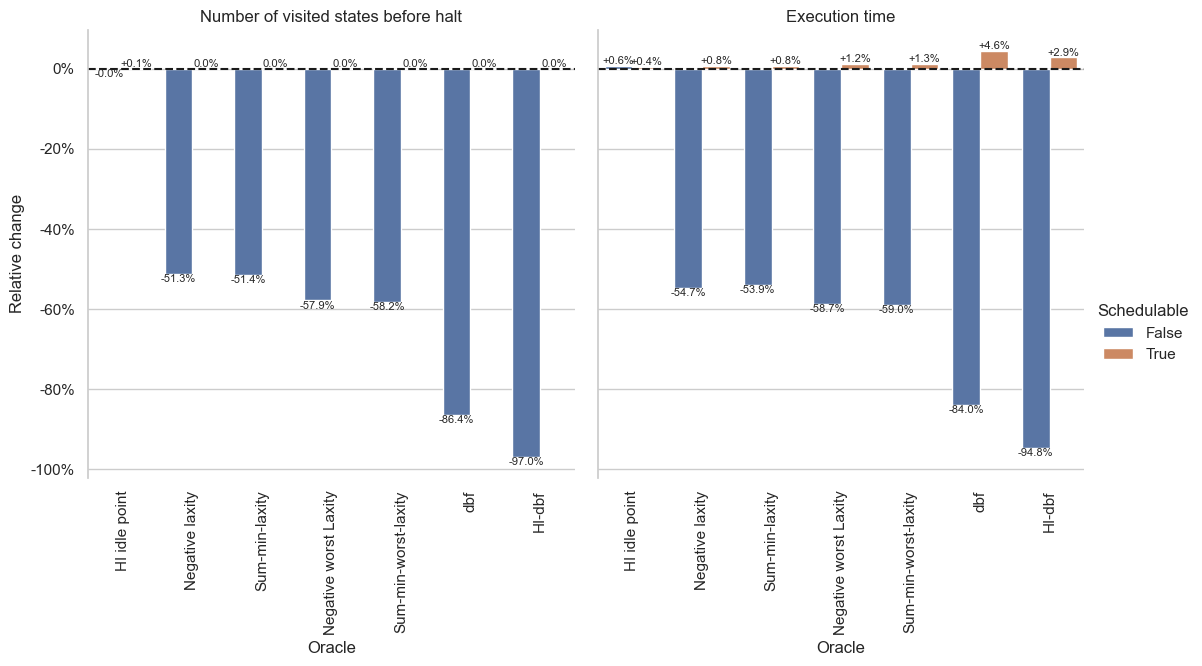

In [34]:
fg = sns.catplot(
    df_comp_melt,
    kind="bar",
    y="Relative change",
    x="Oracle",
    col="Dimension",
    hue="Schedulable",
    height=5.5129,
    aspect=1,
    sharex=False,
    col_order=["Number of visited states before halt", "Execution time"],
    errorbar=None,
    estimator="median",
    order=oracles_order,
)


fg.set_titles("{col_name}")

# draw a dashed vertical line at 0 on the first plot of the face grid
fg.axes[0, 1].axhline(0, color="k", linestyle="--")
fg.axes[0, 0].axhline(0, color="k", linestyle="--")

fg.axes[0, 0].bar_label(fg.axes[0, 0].containers[0], fontsize=8, fmt=fmt_percent_1f)
fg.axes[0, 0].bar_label(fg.axes[0, 0].containers[1], fontsize=8, fmt=fmt_percent_1f)
fg.axes[0, 1].bar_label(fg.axes[0, 1].containers[0], fontsize=8, fmt=fmt_percent_1f)
fg.axes[0, 1].bar_label(fg.axes[0, 1].containers[1], fontsize=8, fmt=fmt_percent_1f)

fg.axes[0, 0].yaxis.set_major_formatter(fmt_percent)


sns.despine(fg.figure, bottom=True)

fg.set_xticklabels(rotation=90)

fg.savefig(
    f"{datetime.now().strftime('%Y%m%d_%H%M%S')}_oracle.pdf", bbox_inches="tight"
)

In [31]:
df_comp_melt.groupby(["Oracle", "Dimension", "Schedulable"])["Relative change"].median()

Oracle                 Dimension                             Schedulable
HI idle point          Execution time                        False           0.626510
                                                             True            0.382319
                       Number of visited states before halt  False          -0.005804
                                                             True            0.093267
HI-dbf                 Execution time                        False         -94.805122
                                                             True            2.855643
                       Number of visited states before halt  False         -97.017498
                                                             True            0.000000
Negative laxity        Execution time                        False         -54.706628
                                                             True            0.787152
                       Number of visited states before halt  False 

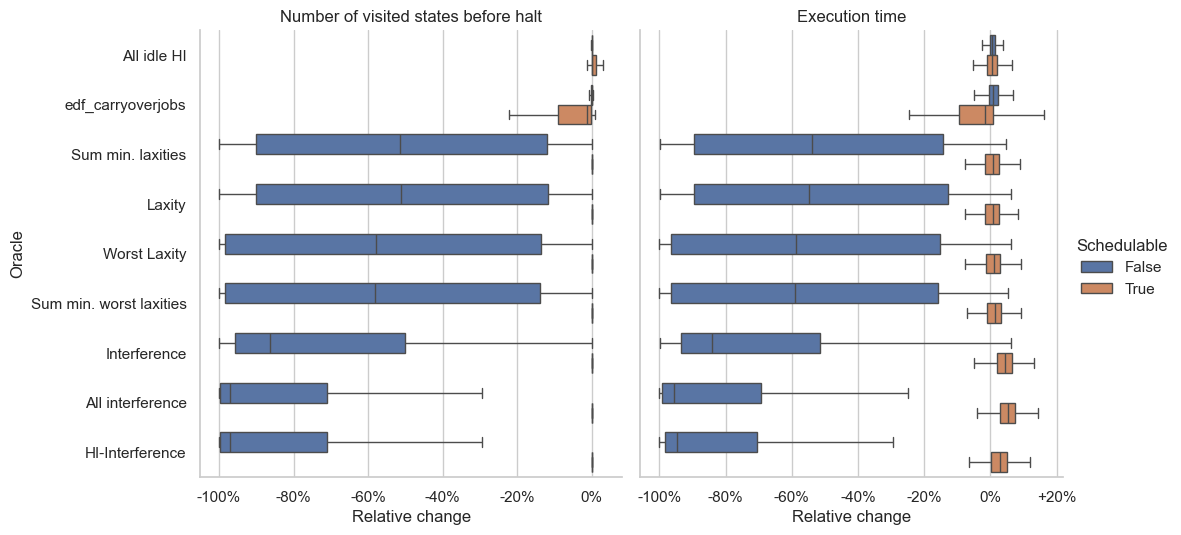

In [18]:
df_comp_melt.groupby(["Oracle", "Dimension", "Schedulable"])["Relative change"].median()

In [ ]:
fg = sns.catplot(
    df_comp_melt,
    kind="box",
    x="Relative change",
    y="Oracle",
    col="Dimension",
    hue="Schedulable",
    height=5.5129,
    aspect=1,
    sharex=False,
    col_order=["Number of visited states before halt", "Execution time"],
    showfliers=False,
    order=oracles_order,
)


fg.set_titles("{col_name}")

# fg.axes[0, 0].xaxis.set_major_formatter(mtick.PercentFormatter(xmax=100))
fg.axes[0, 0].xaxis.set_major_formatter(fmt_percent)
fg.axes[0, 1].xaxis.set_major_formatter(fmt_percent)

fg.savefig(
    f"{datetime.now().strftime('%Y%m%d_%H%M%S')}_oracle_box.pdf", bbox_inches="tight"
)